# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os, cv2
from tqdm.auto import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data 1

In [4]:
from keras.datasets import mnist

Using TensorFlow backend.


In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train,  y_test))

del X_train, X_test, y_train, y_test

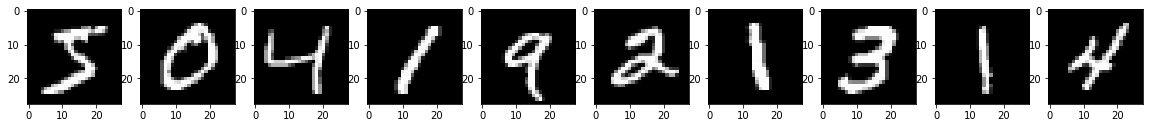

In [6]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X_all[i],cmap=plt.get_cmap('gray'))

In [7]:
X_all = 255 - X_all

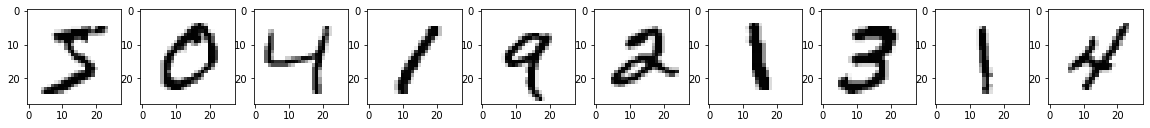

In [8]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X_all[i],cmap=plt.get_cmap('gray'))

# Data 2

In [9]:
X = []
y = []

for i, label in tqdm(enumerate(os.listdir('../Data/MathSymbols-balanced/'))):
    for img in os.listdir(f'../Data/MathSymbols-balanced/{label}'):
        im = cv2.cvtColor(plt.imread(f'../Data/MathSymbols-balanced/{label}/{img}', 0), cv2.COLOR_RGB2GRAY)
        X.append(im)
        y.append(i+10)
        
X = np.array(X)
y = np.array(y)

p = np.random.permutation(len(X))
X, y =  X[p], y[p]

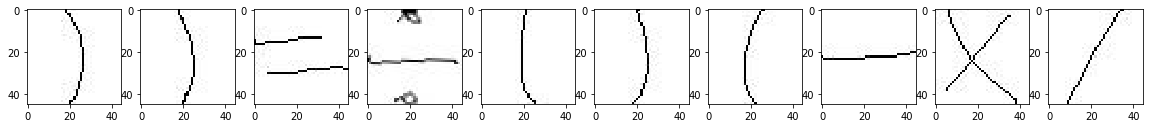

In [10]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X[i],cmap=plt.get_cmap('gray'))

In [11]:
def pad_img(img, pad_size=3, size=(28, 28)):
    return (cv2.resize(
        cv2.copyMakeBorder(img, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, value=255), 
        size
    ))

In [12]:
X_cpy = X
X = []
for img in X_cpy:
    X.append(pad_img(img, pad_size=5, size=(55, 55)))
X = np.array(X)

del X_cpy

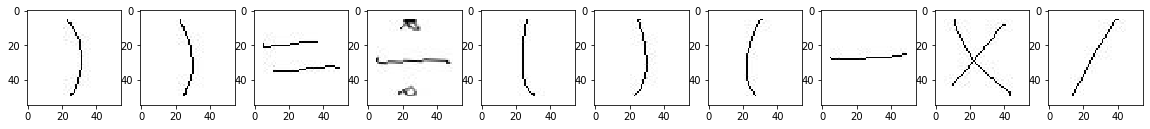

In [13]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X[i],cmap=plt.get_cmap('gray'))

In [14]:
def erode_img(img, kernel=np.ones((2,2),np.uint8), iters=2, size=(28, 28)):
    return (cv2.resize(
        cv2.erode(img, kernel=kernel, iterations=iters), 
        size
    ))

In [15]:
X_cpy = X
X = []
for img in X_cpy:
    X.append(erode_img(img))
X = np.array(X)

del X_cpy

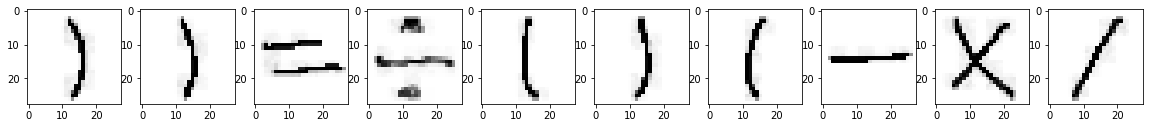

In [16]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X[i],cmap=plt.get_cmap('gray'))

In [17]:
X_all = np.concatenate((X_all, X))
y_all = np.concatenate((y_all,  y))

del X, y

In [18]:
X_all = X_all.astype('float32')
X_all /= 255.0

# Preprocessing

In [19]:
from keras.utils.np_utils import to_categorical

In [20]:
X_all = X_all.reshape(-1, 28, 28, 1)

X_all.shape

(119022, 28, 28, 1)

In [21]:
y_all = to_categorical(y_all)

y_all.shape

(119022, 17)

# Model Fitting

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

## Convolutional Neural Network

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
filepath = "lens-maths.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(patience=2)

def cnn(image_size):
    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape = (*image_size, 1), activation = 'relu', padding='same'))
    classifier.add(Conv2D(64, (5, 5), activation = 'relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))
    classifier.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
    classifier.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))
    classifier.add(Flatten())
    classifier.add(Dense(units = 17, activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    classifier.summary()
    return classifier


model = cnn((28,28))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)        

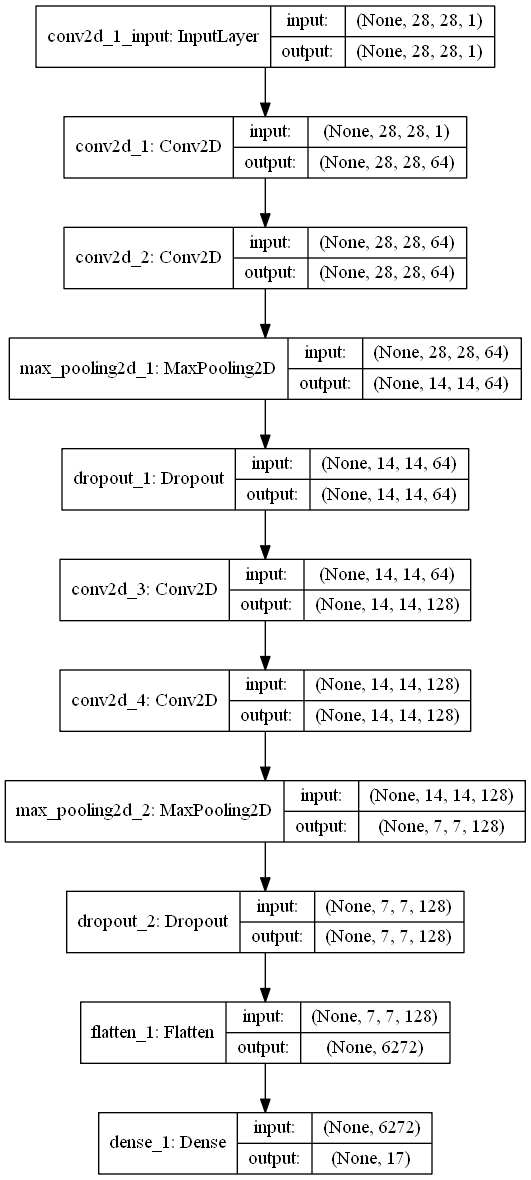

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [26]:
datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range = 0.1,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    validation_split=0.1
)  

datagen.fit(X_all)

training_set = datagen.flow(
    x=X_all, y=y_all,
    subset='training'
)

validation_set = datagen.flow(
    x=X_all, y=y_all,
    subset='validation'
)

In [27]:
history = model.fit_generator(training_set, validation_data=validation_set, epochs=1000, callbacks=[es, ckpt, rlp])

Epoch 1/1000
3348/3348 [==============================] - 2316s 692ms/step - loss: 0.2302 - accuracy: 0.9291 - val_loss: 0.0068 - val_accuracy: 0.9647

Epoch 00001: loss improved from inf to 0.23021, saving model to lens-maths.h5
Epoch 2/1000
3348/3348 [==============================] - 2506s 749ms/step - loss: 0.0914 - accuracy: 0.9734 - val_loss: 0.0080 - val_accuracy: 0.9740

Epoch 00002: loss improved from 0.23021 to 0.09143, saving model to lens-maths.h5
Epoch 3/1000
3348/3348 [==============================] - 1367s 408ms/step - loss: 0.0744 - accuracy: 0.9778 - val_loss: 0.0107 - val_accuracy: 0.9819

Epoch 00003: loss improved from 0.09143 to 0.07439, saving model to lens-maths.h5
Epoch 4/1000
3348/3348 [==============================] - 1423s 425ms/step - loss: 0.0450 - accuracy: 0.9870 - val_loss: 0.0041 - val_accuracy: 0.9861

Epoch 00004: loss improved from 0.07439 to 0.04505, saving model to lens-maths.h5
Epoch 5/1000
3348/3348 [==============================] - 1353s 404m

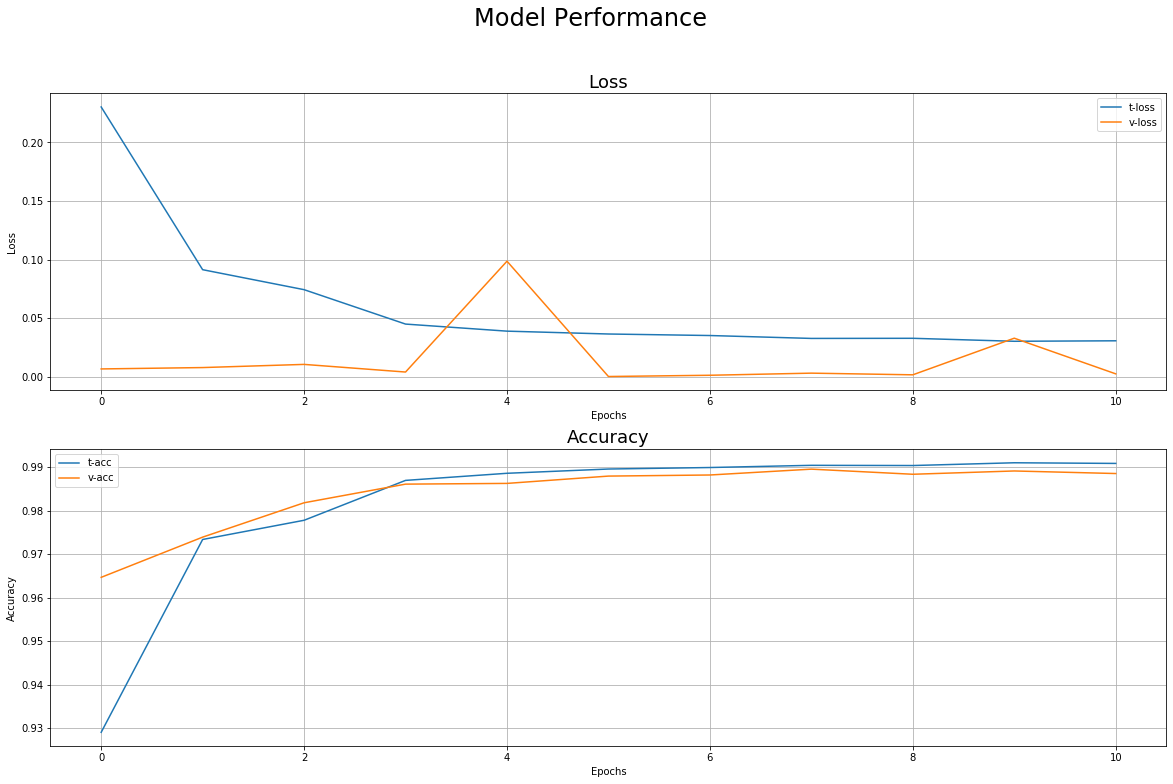

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['accuracy'], label='t-acc')
ax[1].plot(history.history['val_accuracy'], label='v-acc')
ax[1].set_title('Accuracy', fontsize=18)
ax[1].set_ylabel('Accuracy')


for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    
plt.savefig('history.png')    